In [3]:
import matplotlib.pyplot as plt

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

from pathlib import Path
k_Current_dir = Path.cwd()
k_AssetsDir = "assets"

# -----------------------------------------------------------------------------
def cleaner(df):
    df.drop(columns="Unnamed: 2", inplace=True)
    df.drop(columns="Unnamed: 3", inplace=True)
    df.drop(columns="Unnamed: 4", inplace=True)

    df.drop_duplicates(inplace=True)

    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace("/", "_")

    df.rename(columns={"v1": "labels"}, inplace=True)
    df.rename(columns={"v2": "texts"}, inplace=True)

    df["labels"] = df["labels"].map({"ham": 0, "spam": 1})

    return df

# -----------------------------------------------------------------------------
df = pd.read_csv(k_Current_dir / k_AssetsDir / "spam.csv", encoding="cp1252")
df = cleaner(df)
labels = df['labels'].tolist()
texts = df['texts'].tolist()

# Charger le tokenizer et le modèle BERT pré-entraîné
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# max_len = long max d'un sms
def encode_texts(texts, tokenizer, max_len=100):
    return tokenizer(
        texts,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

input_ids = Input(shape=(100,), dtype=tf.int32, name="input_ids")
attention_masks = Input(shape=(100,), dtype=tf.int32, name="attention_mask")

# Extraction des caractéristiques avec BERT
embeddings = bert_model(input_ids, attention_mask=attention_masks)[0]

# Ajout d'une couche de classification
cls_token = embeddings[:, 0, :]
output = Dense(1, activation='sigmoid')(cls_token)

# Définir le modèle
model = Model(inputs=[input_ids, attention_masks], outputs=output)

# Compiler le modèle
model.compile(
    optimizer=Adam(learning_rate=3e-5), 
    loss='binary_crossentropy', 
    # metrics=['accuracy'],
    metrics=[tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision"), "accuracy"],       # name=... avoid recall_1 for example
)

# Résumé du modèle
model.summary()

# Encoder les textes avec BERT tokenizer
encoded_data = encode_texts(texts, tokenizer, max_len=100)

# Division des données en jeux d'entraînement et de test
X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    encoded_data['input_ids'].numpy(), 
    encoded_data['attention_mask'].numpy(), 
    labels, 
    test_size=0.2, 
    random_state=42
)

# Convertir les résultats en tenseurs TensorFlow
X_train_ids = tf.convert_to_tensor(X_train_ids)
X_test_ids = tf.convert_to_tensor(X_test_ids)
X_train_mask = tf.convert_to_tensor(X_train_mask)
X_test_mask = tf.convert_to_tensor(X_test_mask)
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)

# Recombiner les données encodées en dictionnaires pour l'entraînement
X_train = {'input_ids': X_train_ids, 'attention_mask': X_train_mask}
X_test = {'input_ids': X_test_ids, 'attention_mask': X_test_mask}

# Entraînement
history = model.fit(
    [X_train['input_ids'], X_train['attention_mask']],
    y_train, 
    validation_data=([X_test['input_ids'], X_test['attention_mask']], y_test),
    batch_size=32,
    epochs=3
)


c:\Users\phili\anaconda3\envs\att\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassifica

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                           

NameError: name 'save_fig' is not defined

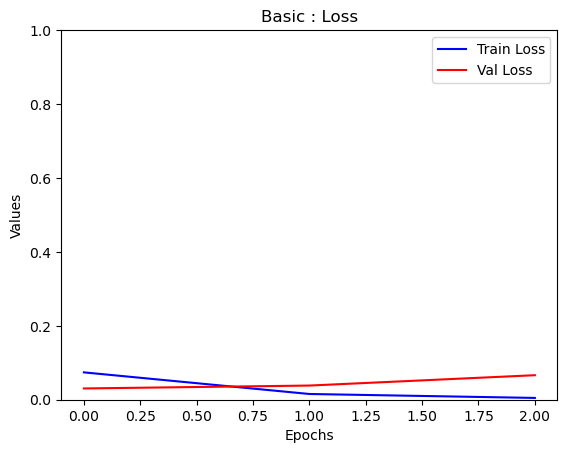

In [4]:
plt.plot(history.history["loss"], color="b", label="Train Loss")
plt.plot(history.history["val_loss"], color="r", label="Val Loss")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("Basic : Loss")
plt.legend()
plt.ylim(0,1)
save_fig("basic_loss", "png")
plt.show()


# display(history.history['loss'][-10:])
display([[round(f, 6) for f in history.history['loss'][-10:]]])
display([[round(f, 6) for f in history.history['val_loss'][-10:]]])
